In [1]:
## Config
path = "../training_1/"
nan_to_neg = True
gkfold_split = 10
biased_regress = True
normal_equations = True
script_name = 'ESN5000_N500std_skf_exp4'
N_def = 500
exponent_def = 4


In [2]:
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt


In [3]:
## Folder and files
fnames = os.listdir(path)  
fnames.sort()
if 'README.md' in fnames:
    fnames.remove('README.md')
print('last file: ', fnames[-1])

n = len(fnames)
print(n, ' files present')

last file:  p05000.psv
5000  files present


In [4]:
## Read data
def read_challenge_data(input_file, return_header = False):
    with open(input_file, 'r') as f:
        header = f.readline().strip()
        column_names = header.split('|')
        data = np.loadtxt(f, delimiter='|')

    # ignore SepsisLabel column if present
    if column_names[-1] == 'SepsisLabel':
        column_names = column_names[:-1]
        data = data[:, :-1]
    return (data)

def read_challenge_data_label(input_file, return_header = False):
    with open(input_file, 'r') as f:
        header = f.readline().strip()
        column_names = header.split('|')
        data = np.loadtxt(f, delimiter='|')

    # ignore SepsisLabel column if present
    if column_names[-1] == 'SepsisLabel':
        sep_lab = data[:,-1] 
        column_names = column_names[:-1]
        data = data[:, :-1]
    if return_header:
        return (data, sep_lab, column_names)

    else:
        return (data, sep_lab)

    # make predictions for each input file
features = []
patient = []
sepsis_label = []
for i in range(n):
    # read data
    input_file = os.path.join(path, fnames[i])
    if i ==0:
        data, sep_lab, columns = read_challenge_data_label(input_file, return_header=True)
    else: 
        data, sep_lab = read_challenge_data_label(input_file)
    features.append(data)
    sepsis_label.append(sep_lab)
    pat = i * np.ones((sep_lab.shape), dtype=np.int)
    patient.append(pat)

feature_matrix = np.concatenate(features)
del(features)
sepsis_label = np.concatenate(sepsis_label)
patient = np.concatenate(patient)


In [5]:
feature_phys = feature_matrix[:,:-6]    ## Physiology
feature_demog = feature_matrix[:,-6:]   ## Demographics

In [6]:
## Get sepsis patients
patient_sep = np.zeros(len(sepsis_label),dtype=np.int)
for i in range(n):
    i_pat = np.where(patient==i)[0]
    patient_sep[i_pat] = int(np.sum(sepsis_label[i_pat])>0)*np.ones(len(i_pat), dtype=np.int)
    
patient_sep_idx = patient[np.where(patient_sep!=0)]
patient_healthy_idx = patient[np.where(patient_sep==0)]

In [7]:
## Normalize std sepsis vals, feature-based
scaler = StandardScaler()
scaler.fit(feature_phys[patient_healthy_idx,:])
feature_phys[:,:] = scaler.transform(feature_phys[:,:])


In [8]:
## nan to negative
if nan_to_neg:
    feature_matrix[np.isnan(feature_matrix)]=-1
    print("Changed nan to -1")

Changed nan to -1


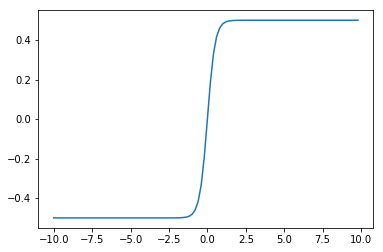

In [9]:
## ESN Generation
N = N_def      # Neurons
mem = 0.1    # memory
scale = 0.2  # scaling factor

# Nonlinear mapping function
def sigmoid(x, exponent):
    return 1/(1+np.exp(-exponent*x))-0.5

sigmoid_exponent = exponent_def
func = sigmoid

a = np.linspace(-10, 10, 100, False)
b = func(a,sigmoid_exponent)
plt.plot(a,b)
plt.show()

In [10]:
# Create ESN 
def feedESN(features, mask, mask_bias, scale, mem):
    ESN = np.ones((np.shape(features)[0],N), dtype=np.double)
    IN = np.matmul(features, M) + np.repeat(Mb, np.shape(features)[0], axis=0)
    print(np.shape(IN))
    print(np.min(IN), np.max(IN))
    p = np.zeros((1,N),dtype=np.double)
    for i in range(np.shape(features)[0]):
        i
        in_val = scale*IN[i,:]+p*mem
        ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
        p = np.copy(np.roll(ESN[i,:],1))
    return ESN

In [11]:
# Mask parameters
M = 2*np.random.rand(np.shape(feature_matrix)[1],N)-1
Mb = 2*np.random.rand(1,N)-1
print(np.shape(M))
print(np.shape(Mb))
print(np.min(M), np.max(M))
print(np.min(Mb), np.max(Mb))

(40, 500)
(1, 500)
-0.9999951800282729 0.9999730502277397
-0.9967840439807836 0.997086417785183


In [12]:
## Perform ESN feed
ESN = feedESN(feature_matrix, M, Mb, scale, mem)

(188453, 500)
-5420.442268828617 5514.543528007932


In [13]:
## Divide in sets
X = ESN
y = sepsis_label
groups = patient

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X)

10

In [14]:
def get_weights_biasedNE(ESN, target):
    ESNx = (np.hstack((ESN, np.ones((np.shape(ESN)[0],1), dtype=np.double))))
    ESNt = np.transpose(ESNx)
    ESNinv = np.linalg.pinv(np.matmul(ESNt,ESNx))
    ESNaux = np.matmul(ESNinv, ESNt)
    w = np.matmul(ESNaux, target)
    return w, ESNaux

def get_weights_biased(ESN, target):
    ESNx = (np.hstack((ESN, np.ones((np.shape(ESN)[0],1), dtype=np.double))))
    ESNinv = np.linalg.pinv(ESNx)
    w = np.matmul(ESNinv, target)
    return w, ESNinv
    

In [15]:
## KFold
results = []
target = []
kk = 0
for train_index, test_index in skf.split(X,y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    if biased_regress:
        if normal_equations:
            w, ESNaux = get_weights_biasedNE(X_train, y_train)
#             ESNx = (np.hstack((X_train, np.ones((np.shape(X_train)[0],1), dtype=np.double))))
            ESNx = (np.hstack((X_test, np.ones((np.shape(X_test)[0],1), dtype=np.double))))

        else:
            w, ESNaux = get_weights_biased(X_train, y_train)
#             ESNx = (np.hstack((X_train, np.ones((np.shape(X_train)[0],1), dtype=np.double))))
            ESNx = (np.hstack((X_test, np.ones((np.shape(X_test)[0],1), dtype=np.double))))

        Y_pred = (np.matmul(ESNx,w))

        
    else:
        ESNinv = np.linalg.pinv(X_train)
        w = np.matmul(ESNinv, y_train)
        Y_pred = (np.matmul(X_test,w))

    print(kk, ' realisation ')
    print("auc: ", roc_auc_score(y_test, Y_pred))
    kk +=1
    target.append(y_test)
    results.append(Y_pred)


0  realisation 
auc:  0.6990601614910721
1  realisation 
auc:  0.6187995528846124
2  realisation 
auc:  0.7195748434369775
3  realisation 
auc:  0.7181695245551936
4  realisation 
auc:  0.7310459407822877
5  realisation 
auc:  0.6949247301050414
6  realisation 
auc:  0.8030090294297545
7  realisation 
auc:  0.7546717368291549
8  realisation 
auc:  0.6865020274214347
9  realisation 
auc:  0.6494721638795699


In [16]:
## Evaluate results
results = np.concatenate(results)
target = np.concatenate(target)
auc = roc_auc_score(target,results)
print('auc: ', auc)

auc:  0.7071357735187276


In [17]:
## Threshold study
th_i = np.min(results)
th_f = np.max(results)
th_steps = 1000
th_step = (th_f-th_i)/th_steps
thsum = 0
th = np.zeros((1000, 1), dtype = np.double)
f1 =np.zeros((1000, 1), dtype = np.double)

print(th_i, th_i+th_step*th_steps)
# for i in range(1000):
for i, j in enumerate(np.arange(th_i, th_f, th_step)):
    th[i] = j
    f1[i] = f1_score(target, results > th[i])
    thsum = thsum + th[i]
#     print(i, th[i], f1[i])
    if i%100 == 0:
        print(i, th[i], f1[i])

    if f1[i] < 0.001 and thsum > 0:
        th = th[:i]
        f1 = f1[:i]
        break


-153.40124883917724 110.46131836210498
0 [-153.40124884] [0.02745519]
100 [-127.01499212] [0.02745533]
200 [-100.6287354] [0.02745533]
300 [-74.24247868] [0.02745533]
400 [-47.85622196] [0.02745548]
500 [-21.46996524] [0.02745591]
600 [4.91629148] [0.]
700 [31.3025482] [0.]
800 [57.68880492] [0.]
900 [84.07506164] [0.]


In [18]:
## Max Threshold
th_max = th[np.argmax(f1)]
th_max

array([0.16676527])

In [19]:
## ACC
Pr = precision_score(target, results > th_max)
Re = recall_score(target, results > th_max)
ACC = accuracy_score(target, results > th_max)
auc = roc_auc_score(target, results)
f1 = f1_score(target, results > th_max)

print('th: ', th_max)
print('Pr: ', Pr)
print('Re: ', Re)
print('F1: ', f1)
print('ACC: ', ACC)
print('AUC: ', auc)

th:  [0.16676527]
Pr:  0.09785714285714285
Re:  0.0522302706824247
F1:  0.06810837683320904
ACC:  0.9801064456389657
AUC:  0.7071357735187276


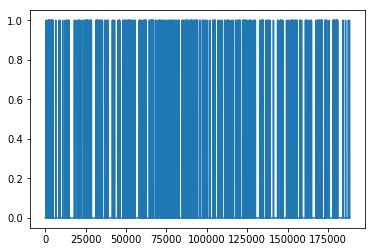

In [20]:
plt.plot(sepsis_label)
plt.show()

In [21]:
patient_sep = np.zeros(len(sepsis_label),dtype=np.int)
for i in range(n):
    i_pat = np.where(patient==i)[0]
    patient_sep[i_pat] = int(np.sum(sepsis_label[i_pat])>0)*np.ones(len(i_pat), dtype=np.int)

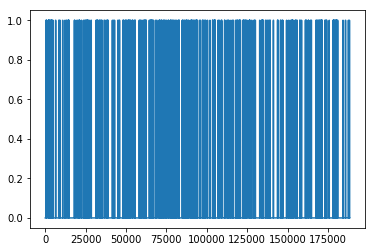

In [22]:
plt.plot(patient_sep)
plt.show()

In [23]:
np.sum(patient_sep)

15524

In [24]:
np.sum(sepsis_label)

2623.0

In [25]:
print('th: %2.4f' % th_max)


th: 0.1668


In [26]:
import platform
import time

user = platform.uname()[1] + '@' + platform.platform() 

# write to report file
output_file = script_name + '.txt'
with open(output_file, 'w') as f:
    f.write(user + '\n')
    f.write(time.strftime("%Y-%m-%d %H:%M") + '\n')
    f.write('Dataset: ' + path + '\n')
    f.write('%d \t N\n' % N)
    f.write('%d \t exp\n' % sigmoid_exponent)
    f.write('%2.4f \t th\n' % th_max)
    f.write('%2.4f \t Pr\n' % Pr)
    f.write('%2.4f \t Re\n' % Re)
    f.write('%2.4f \t F1\n' % f1)
    f.write('%2.4f \t ACC\n' % ACC)
    f.write('%2.4f \t AUC\n' % auc)

In [27]:
user = platform.uname()[1] + '@' + platform.platform() 
print(user)
print(time.strftime("%Y-%m-%d %H:%M"))
print('Dataset: ' + path)
print('N: %d' % N)
print('exp: %d' % sigmoid_exponent)
print('th: %2.4f' % th_max)
print('Pr: %2.4f' % Pr)
print('Re: %2.4f' % Re)
print('ACC: %2.4f' % ACC)
print('AUC: %2.4f' % auc)

LAPTOP-IVRLDJQF@Windows-10-10.0.17763-SP0
2019-04-06 05:23
Dataset: ../training_1/
N: 500
exp: 4
th: 0.1668
Pr: 0.0979
Re: 0.0522
ACC: 0.9801
AUC: 0.7071
